0:	learn: 0.4372271	test: 0.4239586	best: 0.4239586 (0)	total: 49.6ms	remaining: 29.7s
50:	learn: 0.4458488	test: 0.4264588	best: 0.4290655 (28)	total: 1.93s	remaining: 20.8s
100:	learn: 0.4535970	test: 0.4278498	best: 0.4290655 (28)	total: 3.84s	remaining: 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4290655482
bestIteration = 28

Shrink model to first 29 iterations.

✅ Accuracy: 0.40665
✅ F1 Score (weighted): 0.40776446032294345
✅ Precision (weighted): 0.43542060387239834
✅ Recall (weighted): 0.40665
✅ ROC AUC (OvR): 0.5877177353873618

📊 Classification Report:
               precision    recall  f1-score   support

        High       0.28      0.55      0.37      3774
         Low       0.52      0.45      0.49      8497
    Moderate       0.41      0.29      0.34      7729

    accuracy                           0.41     20000
   macro avg       0.41      0.43      0.40     20000
weighted avg       0.44      0.41      0.41     20000



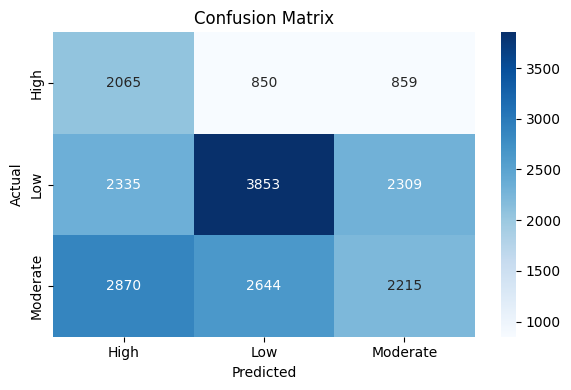

In [8]:
# STEP-0: Install required packages if not already installed
# pip install catboost scikit-learn matplotlib seaborn

import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# STEP-1: Load your dataset
df = pd.read_csv("D:\Diabetes_Unique_Subjective_100k.csv")  # update path if needed
df.drop(columns=["PatientID"], inplace=True)  # drop ID column if present

# STEP-2: Encode target labels
le = LabelEncoder()
df["DiabeticRisk"] = le.fit_transform(df["DiabeticRisk"])  # High/Moderate/Low → 0/1/2

# STEP-3: Identify features
target = "DiabeticRisk"
features = [col for col in df.columns if col != target]
cat_features = df[features].select_dtypes(include='object').columns.tolist()

# STEP-4: Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, stratify=df[target], random_state=42
)

# STEP-5: Convert categorical columns to string and fill NaNs
for col in cat_features:
    X_train[col] = X_train[col].astype(str).fillna("nan")
    X_test[col] = X_test[col].astype(str).fillna("nan")

# STEP-6: Create CatBoost Pools
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# STEP-7: Train CatBoost Model
model = CatBoostClassifier(
    iterations=600,
    learning_rate=0.045,
    depth=7,
    l2_leaf_reg=4,
    random_strength=2.0,
    bootstrap_type="Bayesian",
    bagging_temperature=1.2,
    rsm=0.8,
    loss_function="MultiClass",
    eval_metric="Accuracy",
    custom_metric=["F1", "Precision", "Recall", "AUC"],
    od_type="Iter",
    od_wait=100,
    auto_class_weights="Balanced",
    one_hot_max_size=4,
    random_seed=42,
    verbose=50
)

model.fit(train_pool, eval_set=test_pool)

# STEP-8: Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# STEP-9: Evaluation
print("\n✅ Accuracy:", accuracy_score(y_test, y_pred))
print("✅ F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("✅ Precision (weighted):", precision_score(y_test, y_pred, average='weighted'))
print("✅ Recall (weighted):", recall_score(y_test, y_pred, average='weighted'))
print("✅ ROC AUC (OvR):", roc_auc_score(y_test, y_proba, multi_class='ovr'))

print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# STEP-10: Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


📊 Full Feature Importances:
           Feature Id  Importances
0        StressLevel    24.815499
1       SleepQuality    23.100669
2   Fatigue_Weakness    22.679737
3   PhysicalActivity    22.006183
4               Diet     1.392062
5    Diabetes_Family     1.266427
6      Socioeconomic     1.153600
7           Location     0.970569
8                Age     0.769997
9            Smoking     0.637878
10           Alcohol     0.541394
11           Tobacco     0.363775
12            Gender     0.302209


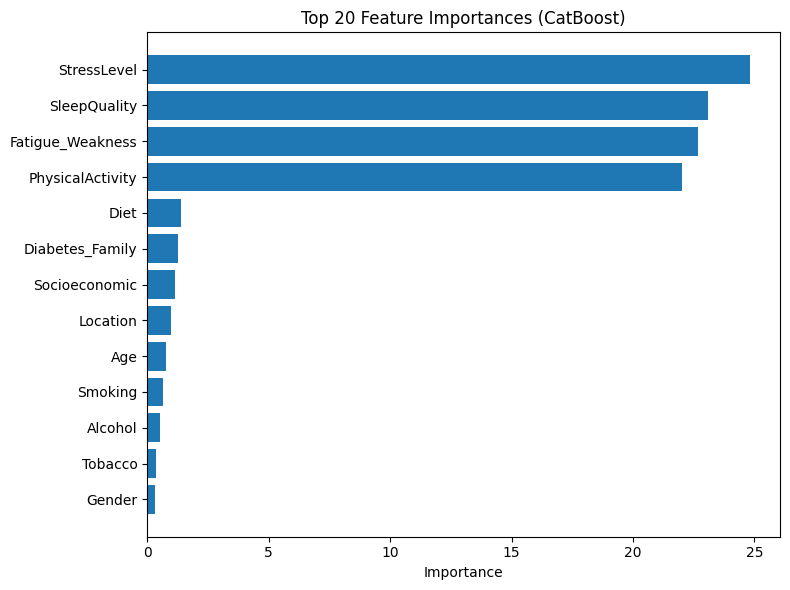

In [9]:
# STEP-11: Feature Importance
import matplotlib.pyplot as plt

# Get feature importances as a DataFrame (prettified=True gives column names)
feature_importance = model.get_feature_importance(train_pool, prettified=True)

# Display full importance table (optional)
print("📊 Full Feature Importances:\n", feature_importance)

# Plot Top 20 Features
top_20 = feature_importance.sort_values(by="Importances", ascending=False).head(20)

plt.figure(figsize=(8, 6))
plt.barh(top_20["Feature Id"], top_20["Importances"])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances (CatBoost)")
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()
